In [1]:
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from urllib import request
from brendapyrser import BRENDA
import html
import pickle
from math import exp
import random
import re
from functions import *

In [2]:
brenda = BRENDA('../../local_data/brenda.txt') # download brenda.txt from https://www.brenda-enzymes.org/download.php.

# Get enzyme optimal temperatures from brenda

In [3]:
def get_entry_ot( ec ):
    r = brenda.reactions.get_by_id(ec)
    all_data = r.temperature['optimum']
    result = []
    for i in range(len(all_data)):
        OT = all_data[i]['value']
        if '#' not in all_data[i]['meta']:
            continue
        p_refs = []
        if ';' in all_data[i]['meta']:
            meta_list = all_data[i]['meta'].split(';')
            for meta in meta_list:
                p_refs += list( meta.split('#')[1].split(',') )
                
        else:
            meta = all_data[i]['meta']
            p_refs += list( meta.split('#')[1].split(',') )
            
        for ref in p_refs:
            if (ref in r.proteins) and (r.proteins[ref]['proteinID'] != ''):
                p_id = r.proteins[ref]['proteinID']
                p_id = p_id.replace('UniProt','').replace('SwissProt','').\
                replace('swissprot','').replace('Uniprot','').replace('TrEMBL','').replace('GenBank','').strip()
                if ' and ' in p_id:
                    p_ids = p_id.split(' and ')
                    for p_id in p_ids:
                        result.append( {'uniprot_id': p_id.strip(),'topt':float(OT)} )        
                elif ' ' in p_id:
                    p_id = max( p_id.split(' '), key=len )
                    result.append( {'uniprot_id': p_id.strip(),'topt':float(OT)} )
                else:
                    result.append( {'uniprot_id': p_id.strip(),'topt':float(OT)} )    
    return result

In [4]:
ec_list = []
for rxn in brenda.reactions:
    ec_list.append( rxn.ec_number )
ec_list = list(set(ec_list))
print(len(ec_list))

7609


In [1]:
# data = []
# idx = 0
# for ec in ec_list:
#     if idx % 500 == 0:
#         print(str(idx) + ' done')
#     data += get_entry_ot( ec )
#     idx+=1

In [6]:
raw_ot = pd.DataFrame(data).dropna().drop_duplicates(subset=['uniprot_id','topt']).reset_index().drop(['index'],axis=1)
raw_ot = raw_ot[raw_ot['topt']>=0].reset_index().drop(['index'],axis=1)
keep_inds = []
for i in list(raw_ot.index):
    temp_id = list(raw_ot['uniprot_id'])[i]
    if len( raw_ot[raw_ot['uniprot_id']==temp_id].index) == 1:
        keep_inds.append(i)
raw_ot = (raw_ot.iloc[keep_inds]).reset_index().drop(['index'],axis=1)
# raw_ot.to_csv('../data/raw_brenda_topt.csv',index=None)

In [11]:
# raw_ot = pd.read_csv('../data/raw_brenda_topt.csv')
# seqs = []
# total = len(raw_ot.index)
# for i in list(raw_ot.index):
#     if i%500 == 0:
#         print( str(i/total)+'% done' ) 
#     temp_id = list(raw_ot['uniprot_id'])[i].strip()
#     temp_seq =get_seq( temp_id )
#     seqs.append(temp_seq)
# raw_ot['sequence'] = seqs
# raw_ot = raw_ot.dropna().reset_index().drop(['index'],axis=1)
# raw_ot.to_csv('../data/brenda_topt.csv',index=None)

0.0% done
0.08986340762041696% done
0.17972681524083392% done
0.2695902228612509% done
0.35945363048166784% done
0.44931703810208484% done
0.5391804457225018% done
0.6290438533429188% done
0.7189072609633357% done
0.8087706685837527% done
0.8986340762041697% done
0.9884974838245866% done


# Merge Brenda data with TOME data

In [15]:
brenda_topt = (pd.read_csv('../data/brenda_topt.csv')).dropna().reset_index().drop(['index'],axis=1)
tome_topt = pd.read_csv('../data/sequence_ogt_topt.csv') # obtained from TOMER (https://doi.org/10.1021/acs.jcim.0c00489)
tome_topt = tome_topt[['uniprot_id','topt','sequence']]
remove_idx =[]
for i in list(brenda_topt.index):
    if len(brenda_topt['sequence'][i]) < 50:
        remove_idx.append(i)
brenda_topt = (brenda_topt.drop(remove_idx)).reset_index().drop(['index'],axis=1)
topt_data = (pd.concat([brenda_topt, tome_topt]) ).drop_duplicates(subset=['uniprot_id','topt','sequence']).\
                                        reset_index().drop(['index'],axis=1)
# remove conflicting data
remove_idx=[]
for i in list(topt_data.index):
    temp_seq = topt_data['sequence'][i]
    temp_pd = topt_data[ topt_data['sequence']==temp_seq ]
    if len(temp_pd.index) > 1:
        remove_idx.append(i)
topt_data = ( topt_data.drop(remove_idx) ).reset_index().drop(['index'],axis=1)
# topt_data.to_csv('../data/topt_data.csv',index=None)

# Dataset split

In [18]:
topt_data = pd.read_csv('../data/topt_data.csv')

In [20]:
def split_table( table, ratio ):
    idx=list(table.index)
    np.random.shuffle(idx)
    num_split = int( len(idx) * ratio)
    idx_test, idx_train = idx[:num_split], idx[num_split:]
    train_table = (table.iloc[idx_train]).reset_index().drop(['index'],axis=1)
    test_table = (table.iloc[idx_test]).reset_index().drop(['index'],axis=1)
    return train_table,test_table

In [31]:
train, test = split_table(topt_data, ratio=0.1)

In [32]:
# train.to_csv('../data/train.csv',index=None)
# test.to_csv('../data/test.csv',index=None)

In [35]:
train = pd.read_csv('../data/train.csv'); test=pd.read_csv('../data/test.csv');

In [38]:
# Oversampling for T >= 80 C
train_os = train.copy()
high_ot = (train[train['topt']>=80]).reset_index().drop(['index'],axis=1)
over_high = []
for i in range( len(high_ot.index) ):
    rand_idx = np.random.randint( len( high_ot.index ) - 1,size=1)[0]
    temp_data = dict( high_ot.iloc[rand_idx] )
    over_high.append( temp_data )
over_pd = pd.DataFrame(over_high)
train_os = ( pd.concat([ train_os, over_pd]) ).reset_index().drop(['index'],axis=1)
# train_os.to_csv('../data/train_os.csv',index=None)

In [39]:
train_os = pd.read_csv('../data/train_os.csv')

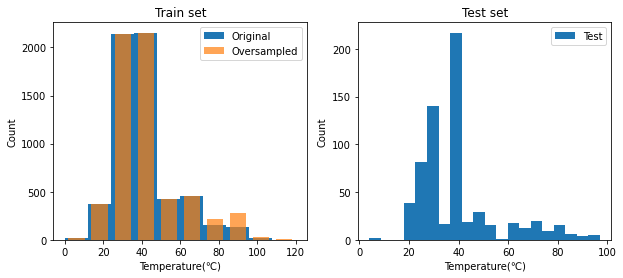

In [52]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(train['topt'],alpha=1,label='Original');
axs[0].hist(train_os['topt'],alpha=0.7, histtype='barstacked',rwidth=0.7, label='Oversampled')
axs[0].set_title('Train set')
axs[1].hist(test['topt'], bins=20, label='Test');
axs[1].set_title('Test set')
for ax in axs:
    ax.set_xlabel('Temperature(\u2103)')
    ax.set_ylabel('Count')
    ax.legend()

# Generate 3-mer dict

In [56]:
train_os = pd.read_csv('../data/train_os.csv'); test=pd.read_csv('../data/test.csv');
all_seqs = list( set( list( train_os['sequence'] ) + list( test['sequence'] ) ) )
letters = list( set(''.join(all_seqs)) )
word_dict = {}
def check_word(kmer, w_dict):
    if kmer in w_dict:
        return None
    elif len(w_dict.keys()) == 0:
        w_dict[kmer] = 0
    else:
        w_dict[kmer] = max(list(w_dict.values())) + 1
    return None
        
for x in letters:
    for y in letters:
        kmer_0='>'+x+y; kmer_1=x+y+'<';
        check_word(kmer_0, word_dict)
        check_word(kmer_1, word_dict)
for x in letters:
    for y in letters:
        for z in letters:
            check_word( x+y+z, word_dict)

In [59]:
# dump_pickle(word_dict, '../data/word_dict.pkl')

# Default hyperparameters

In [2]:
# default_dict = { 'dim': 64,'window':5,'dropout':0.5,'layer_cnn':3,'layer_out': 4 }
# dump_pickle(default_dict, '../data/performances/default.pkl')